---
title: Predict Consortia Phenotype
author: Benjamin Doran
date: Dec 2023
---

In [15]:
#| code-summary: julia setup
#| code-fold: true
using DrWatson
@quickactivate projectdir()

using SpectralInference
using NewickTree
using StatsBase
using Muon, CSV, DataFrames
using StatsPlots, GLM
theme(:default, grid=false, label=false, tickdir=:out)

ddir = datadir("exp_raw", "BBconsortia");
predsdir = projectdir("_research", "metabolite_SLE_Lasso_model_outofbag");

## Compare 3 member consortia measurements to added strain predictions

In [32]:
biobank = readh5mu(datadir("exp_raw", "BB669", "BB669.h5mu"));
full_train_mask = biobank.obs.kept_species .== 1
bbobs_trn = biobank.obs[full_train_mask, :];

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon /Users/bend/.julia/packages/Muon/eLqpV/src/mudata.jl:351


In [33]:
unique_condf = CSV.read(joinpath(ddir, "needisolate_oggs.csv"), DataFrame);
consortiadf = CSV.read(joinpath(ddir, "full_PFBBR_consortia.csv"), DataFrame)
fconsortiadf = filter(:compound => in(["butyrate", "acetate", "succinate", "propionate"]), consortiadf) |> 
    df->select(df, [:con_id, :con_list, :msk_id, :input_condition, :media, :ph_adjust, :compound, :log2FC]);

oofpreds = CSV.read(joinpath(predsdir, "oof_predictions_stacked_SPItreeLASSO_ancestralencoding_lambda=0.001.csv"), DataFrame);
oobpreds = CSV.read(joinpath(predsdir, "oob_predictions_stacked_SPItreeLASSO_ancestralencoding_lambda=0.001.csv"), DataFrame);
added_isolate_mskids = String.(unique(fconsortiadf.msk_id))
@show added_isolate_mskids;

added_isolate_mskids = ["DFI.3.84", "DFI.6.78", "DFI.4.30", "DFI.5.64", "DFI.1.19", "DFI.5.28", "MSK.6.3", "DFI.5.40", "DFI.5.67", "MSK.11.20", "SL.2.19", "MSK.14.17", "DFI.5.75", "MSK.16.22", "MSK.17.84", "DFI.5.16", "DFI.7.37"]


In [34]:
unique_condf.species_in_strvar .= sum(unique_condf.name .== permutedims(unique(bbobs_trn.Species)), dims=2);
unique_condf.genus_in_strvar .= sum(first.(split.(unique_condf.name, " ")) .== permutedims(first.(split.(unique(bbobs_trn.Species), " "))), dims=2);
select(unique_condf, [:msk_id, :name, :genus_in_strvar])

Row,msk_id,name,genus_in_strvar
,String15,String31,Int64
1,DFI.1.234,[Clostridium] scindens,0
2,DFI.2.45,Bifidobacterium longum,1
3,DFI.3.84,Coprococcus comes,1
4,DFI.6.78,Anaerobutyricum soehngenii,0
5,DFI.4.30,Anaerostipes hadrus,1
6,DFI.1.19,Anaerostipes caccae,1
7,DFI.5.28,[Eubacterium] rectale,1
8,MSK.6.3,Roseburia faecis,0
9,DFI.5.40,Faecalibacterium prausnitzii,0


In [35]:
# out-of-fold predictions for added isolates (average and std over resamples)
oof_wide = subset(oofpreds,
        # :msk_id => x->.∈(x, Ref(added_isolate_mskids)),
        :msk_id => ByRow(∈(added_isolate_mskids)),
        :metabolite_name => ByRow(∈(["Acetate", "Butyrate", "Propionate", "Succinate"])),
    ) |>
df -> sort(df, [:msk_id, :metabolite_name]) |>
df -> unstack(df, [:msk_id, :resample], :metabolite_name, :preds) |>
df -> groupby(df, [:msk_id]) |>
df -> combine(df, 
    3:6 .=> mean,
    3:6 .=> std,
);

In [36]:
# out-of-bag predictions (average and std over resamples)
oob_wide = subset(oobpreds,
        :msk_id => ByRow(∈(added_isolate_mskids)),
        :metabolite_name => ByRow(∈(["Acetate", "Butyrate", "Propionate", "Succinate"])),
    ) |>
df -> sort(df, [:msk_id, :metabolite_name, :fold, :resample]) |>
df -> unstack(df, [:msk_id, :resample], :metabolite_name, :preds, combine=first) |>
df -> groupby(df, [:msk_id]) |>
df -> combine(df, 
    3:6 .=> mean,
    3:6 .=> std,
);

In [37]:
addedisolate_preds = vcat(oof_wide, oob_wide)

Row,msk_id,Acetate_mean,Butyrate_mean,Propionate_mean,Succinate_mean,Acetate_std,Butyrate_std,Propionate_std,Succinate_std
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,DFI.3.84,1.54362,5.67077,-0.233056,-0.767597,0.0227796,0.023164,0.0033514,0.0102699
2,DFI.4.30,-1.13629,5.06859,1.97317,-0.951255,0.634897,2.18694,1.00431,0.356204
3,MSK.11.20,-0.419323,6.70012,3.10775,-0.594025,0.22129,0.0468537,0.915711,0.0653226
4,MSK.14.17,-0.936271,6.601,2.52386,-1.02732,0.559588,0.240671,1.00271,0.293703
5,MSK.16.22,0.16895,5.73695,0.119979,0.340988,0.414207,0.108866,0.123442,0.86982
6,DFI.1.19,-0.34663,2.77478,1.22566,-0.715933,0.280964,3.48805,1.1707,0.0861858
7,MSK.6.3,0.504984,5.73143,0.0837137,0.70721,0.225006,0.0156853,0.0703886,0.119016
8,DFI.5.64,2.67552,-0.212986,-0.438936,0.632796,0.386428,0.045966,0.194182,1.23303
9,MSK.17.84,0.53399,5.73143,0.0832299,0.698754,0.169405,0.0156853,0.0704271,0.210429


In [38]:
# metabolte concentrations of 3 member consortia (averaged over media conditions)
merged_con_measures = fconsortiadf |> 
    df->groupby(df, [:con_id, :con_list, :msk_id, :compound]) |>
    df->combine(df, 
        :log2FC => mean,
        :log2FC => std,
    ) #|>
    # df->subset(df, :msk_id => x->.!(x .∈ Ref(strvar_mskids)))
merged_con_measures_wide = leftjoin(
    unstack(merged_con_measures, 1:3, :compound, :log2FC_mean),
    unstack(merged_con_measures, 1, :compound, :log2FC_std), on=:con_id, makeunique=true)
newcolnames = [
    :acetate => :acetate_mean,
    :butyrate => :butyrate_mean,
    :propionate => :propionate_mean,
    :succinate => :succinate_mean,
    :acetate_1 => :acetate_std,
    :butyrate_1 => :butyrate_std,
    :propionate_1 => :propionate_std,
    :succinate_1 => :succinate_std,
]
rename!(merged_con_measures_wide, newcolnames)

Row,con_id,con_list,msk_id,butyrate_mean,acetate_mean,propionate_mean,succinate_mean,butyrate_std,acetate_std,propionate_std,succinate_std
,String7,String31,String15,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,CON.084,"DFI.1.234,DFI.2.45,DFI.3.84",DFI.3.84,4.55624,2.79497,-0.29222,0.0259156,0.876702,0.217815,0.433933,0.0582666
2,CON.085,"DFI.1.234,DFI.2.45,DFI.6.78",DFI.6.78,5.62454,2.3551,0.278347,0.123691,0.443752,0.395852,0.0803643,0.0760432
3,CON.086,"DFI.1.234,DFI.2.45,DFI.4.30",DFI.4.30,6.14297,0.931719,2.36774,-0.0618057,0.365015,0.740421,0.444337,0.0807273
4,CON.092,"DFI.1.234,DFI.2.45,DFI.5.64",DFI.5.64,6.88241,3.44515,0.467723,0.112728,0.332509,0.369505,0.22223,0.26109
5,CON.087,"DFI.1.19,DFI.1.234,DFI.2.45",DFI.1.19,6.72225,1.59332,0.940054,-0.0210095,0.0682819,0.222954,0.0622343,0.080052
6,CON.088,"DFI.1.234,DFI.2.45,DFI.5.28",DFI.5.28,3.23979,2.1665,-0.00734626,-0.0386782,1.00149,0.140506,0.484648,0.028282
7,CON.089,"DFI.1.234,DFI.2.45,MSK.6.3",MSK.6.3,4.79528,1.96362,-0.0682856,0.00460516,0.229041,0.0417746,0.808534,0.0147493
8,CON.090,"DFI.1.234,DFI.2.45,DFI.5.40",DFI.5.40,3.20835,2.72607,-0.305818,0.0441199,1.85737,0.552205,0.423246,0.10503
9,CON.121,"DFI.1.234,DFI.2.45,DFI.5.67",DFI.5.67,6.12427,1.41821,-0.0963225,0.0531609,0.337785,0.444643,0.0413068,0.371393


In [39]:
# merge everthing together based on added isolate
pltdf = leftjoin(merged_con_measures_wide, addedisolate_preds, on=:msk_id)
pltdf = leftjoin(pltdf, unique_condf, on=:msk_id);

In [40]:
CSV.write(joinpath(ddir, "merged_consortia-and-isolate_plotdata.csv"), pltdf)

"/Users/bend/projects/Doran_etal_2023/data/exp_raw/BBconsortia/merged_consortia-and-isolate_plotdata.csv"

### linear models

Here we make linear models for the consortia measurements versus predictions, factored by if the consortia's added strain has a member of the same genus in the training set or not.

only the model of consortia with a member of the same genus in the training set has a significant slope

In [41]:
model_notinstrvar = lm(@formula(acetate_mean ~ Acetate_mean), filter(:genus_in_strvar => ==(0), pltdf))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

acetate_mean ~ 1 + Acetate_mean

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error     t  Pr(>|t|)   Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)   2.13519     0.278308  7.67    0.0001   1.4771       2.79328
Acetate_mean  0.209217    0.126753  1.65    0.1428  -0.0905065    0.50894
─────────────────────────────────────────────────────────────────────────

In [42]:
model_instrvar = lm(@formula(acetate_mean ~ Acetate_mean), filter(:genus_in_strvar => ==(1), pltdf))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

acetate_mean ~ 1 + Acetate_mean

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)   1.95874      0.14264  13.73    <1e-05   1.60971    2.30777
Acetate_mean  0.498511     0.13533   3.68    0.0103   0.167371   0.829651
─────────────────────────────────────────────────────────────────────────

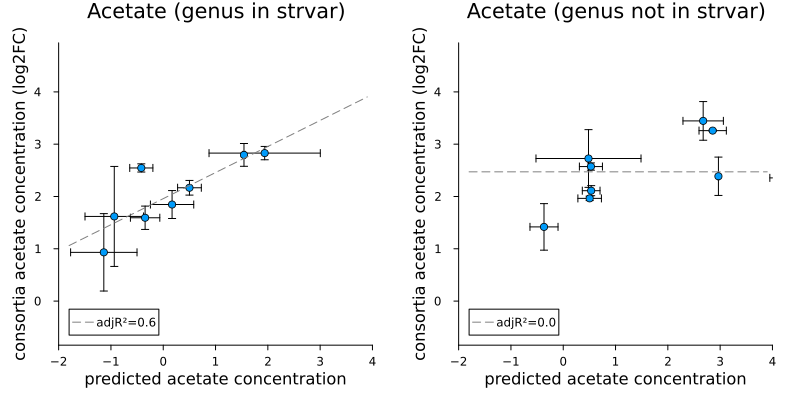

In [43]:
p1 = plot(title="Acetate (genus in strvar)", 
    xlabel="predicted acetate concentration",
    ylabel="consortia acetate concentration (log2FC)",
    alpha=.5, 
    ratio=1,
)
@df filter(:genus_in_strvar => ==(1), pltdf) scatter!(
    :Acetate_mean, :acetate_mean, 
    xerror=:Acetate_std, yerror=:acetate_std,
)
plot!(x->predict(model_instrvar, [(;Acetate_mean=x)])[1],-1.8, 3.9,
    c=:grey, linestyle=:dash,
    label="adjR²=$(round(adjr2(model_instrvar), digits=1))",
)  

p2 = plot(title="Acetate (genus not in strvar)", 
    xlabel="predicted acetate concentration",
    ylabel="consortia acetate concentration (log2FC)",
    alpha=.5, 
    ratio=1,
)
@df filter(:genus_in_strvar => ==(0), pltdf) scatter!(
    :Acetate_mean, :acetate_mean, 
    xerror=:Acetate_std, yerror=:acetate_std,
)
@df filter(:genus_in_strvar => ==(0), pltdf) plot!(
    x->mean(:acetate_mean), -1.8, 3.9,
    c=:grey, linestyle=:dash,
    label="adjR²=0.0",
)


plot(p1, p2, 
    layout=grid(1,2), 
    legend=:bottomleft, size=(800,400),
    margin=5Plots.mm,
    xlims=(-2, 4),
    link=:y
    )  

## Consortia Baseline

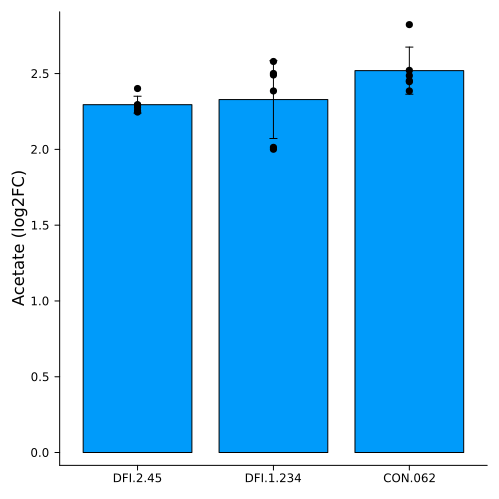

In [30]:
smpmap = CSV.read(joinpath(ddir, "DFI_HMMF_1256_biobank-evnin_EW021622-5c6e08.tsv"), DataFrame; delim="\t");
df = CSV.read(joinpath(ddir, "removed_qcs_quant_results_20220301_PFBBr_EVIT1256_20220304.csv"), DataFrame);
df = leftjoin(smpmap, df, on=:HMMF_sampleid => :sampleid);
keepids = [
    "DFI.2.45",
    "DFI.1.234",
    "CON.062",
]
subset(df, :msk_id => ByRow(∈(["blank"]))) |> 
    df -> sort(df, [:msk_id, "taurocholic_acid__ug.ml"]) |>
    df -> select(df, 
        :msk_id,
        "taurocholic_acid__ug.ml" => :condition,
        :Acetate,
        :Butyrate, 
        :Propionate,
        :Succinate,
    ) |>
    df -> groupby(df, [:msk_id, :condition]) |>
    df -> combine(df, [:Acetate, :Butyrate,:Propionate, :Succinate] .=> mean)
pltdf = subset(df, :msk_id => ByRow(∈(keepids))) |> 
    df -> sort(df, [:msk_id, "taurocholic_acid__ug.ml"]) |>
    df -> select(df, 
        :msk_id,
        "taurocholic_acid__ug.ml" => :condition,
        :Acetate,
        :Butyrate, 
        :Propionate,
        :Succinate,
    ) |>
    df -> transform(df,
        :Acetate => ByRow(x->log2(x/4.3)) => :Acetate_log2FC
    )
plot(ylabel="Acetate (log2FC)",)
groupby(pltdf, :msk_id) |>
    df -> combine(df,
        :Acetate_log2FC => mean,
        :Acetate_log2FC => std,
    ) |>
    x->@df x bar!(:msk_id, :Acetate_log2FC_mean, 
        yerror=:Acetate_log2FC_std,
        # xticks=(1:3, :msk_id)
    )


@df pltdf scatter!(:msk_id, 
    :Acetate_log2FC, 
    c=:black, widen=true, size=(500,500),
    
)